### Plotting GEFS 0.5 degree
The Global Ensemble Forecast System (GEFS) is the backbone of our Clyfar data collection that serves as initial conditions (input values) to the inference stage. It is a global model, and uses degree of latitude to measure the width of the grid-cells (think of the GEFS data as a 3D block of cubes each with information about that block of air like its temperature, speed, etc). We would prefer the higher resolution 0.25 degree data (`gefs_0p25` or `0p25` in some of the API keys etc) -- corresponding to about 25 km -- but it is newer and some of it causes errors in `Herbie`. Until we work all that out, the coarser `0p5` should be used as a fall-back in some uses.

Here is what the data look like on a map so it's easier to conceptualise. This data next need to reducing to "representative values" that mimic representative observations of ozone and weather obs around the Basin. Further, we want to test more including:

* Saving and loading to file
* How much data to save
* How to slice (and save) and visualise cross-sections (i.e., we'd see the cold pool in NWP data as a dome of cold air)
* How things like mountains look in 0.5 degree data, versus 0.25 degree GEFS and 3km HRRR/RRFS in future.

In [1]:
import importlib
import datetime

import pytz
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from viz import plotting
from utils.lookups import elevations
from nwp.hrrrdata import HRRRData
from nwp.gefsdata import GEFSData
import utils.utils as utils
from nwp.gefsdata import GEFSData
from nwp.download_funcs import load_variable

from preprocessing.representative_obs import (
    do_repval_snow,
    do_repval_mslp,
    do_repval_wind,
    do_repval_solar
)

from obs.obsdata import ObsData

/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
lon, lat = (360 - 109.6774, 40.0891) # Where is this?
init_dt = datetime.datetime(2023,2,15,0,0,0)
init_dt_tz = init_dt.astimezone(pytz.timezone("UTC"))
local_t0 = init_dt.astimezone(pytz.timezone('US/Mountain'))
my_extent = [-110.9, -108.2, 41.3, 39.2]
fchr = 0
remove_grib = False

year = 2023
snow_stids = ['COOPJENU1', 'COOPFTDU1', 'COOPALMU1', 'COOPDINU1', 'COOPROSU1',
              'COOPVELU1', 'COOPDSNU1', 'COOPOURU1', 'COOPNELU1']
wind_stids = ['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']
solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"] # NOW VERY DIFFERENT
mslp_stids = ["KVEL",]


In [4]:
def plot_ensemble_members(ds_time_series, variable, repr_data, max_h,
                            init_dt, repr_col, label, decimal_places=3):
    """
    Function to plot ensemble members.

    Args:
        ds_time_series (xarray.Dataset): Time series dataset of the ensemble members.
        variable (str): Variable name to plot.
        repr_data (pandas.DataFrame): Representative data for comparison.
        max_h (int): Maximum forecast hour.
        init_dt (datetime.datetime): Initial datetime.
        repr_col (str): Column name in the representative data.
        label (str): Label for the variable.
        decimal_places (int): Number of decimal places for annotation.
    """
    fig, ax = plt.subplots(1)
    for i in range(ds_time_series[variable].shape[1]):
        for j in range(ds_time_series[variable].shape[2]):
            # First, build some key-word arguments for matplotlib to make plot prettier
            mpl_kwargs = {'alpha': 0.5, 'linestyle': '-', 'linewidth': 0.5}
            ax.plot(ds_time_series.time, ds_time_series[variable][:, i, j],
                    **mpl_kwargs)

    # Subset the representative data to the time range of the GEFS data
    gefs_time0 = init_dt
    gefs_time1 = init_dt + datetime.timedelta(hours=max_h)

    import pytz
    mountain_tz = pytz.timezone('US/Mountain')
    gefs_time0 = mountain_tz.localize(gefs_time0)
    gefs_time1 = mountain_tz.localize(gefs_time1)

    repr_data_subset = repr_data.loc[gefs_time0:gefs_time1]
    ax.plot(repr_data_subset.index, repr_data_subset[repr_col], color='black', linestyle='--')

    ax.set_title(f'{label}')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{label} ({variable})')
    plt.show()


### Plotting a surface map
The following shows snow depth at 12 hours from the initial time from the GEFS model

TODO: use `FastHerbie` for faster data retrieval if possible

In [5]:
H = GEFSData.setup_herbie(init_dt, fxx=fchr, product="atmos.5", model="gefs",member='p01')
H.inventory()

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,?,search_this
0,1,0,253903.0,0-253903,2023-02-15,2023-02-15,HGT,10 mb,anl,ENS=+1,:HGT:10 mb:anl:ENS=+1
1,2,253904,382590.0,253904-382590,2023-02-15,2023-02-15,TMP,10 mb,anl,ENS=+1,:TMP:10 mb:anl:ENS=+1
2,3,382591,444039.0,382591-444039,2023-02-15,2023-02-15,RH,10 mb,anl,ENS=+1,:RH:10 mb:anl:ENS=+1
3,4,444040,598001.0,444040-598001,2023-02-15,2023-02-15,UGRD,10 mb,anl,ENS=+1,:UGRD:10 mb:anl:ENS=+1
4,5,598002,744912.0,598002-744912,2023-02-15,2023-02-15,VGRD,10 mb,anl,ENS=+1,:VGRD:10 mb:anl:ENS=+1
...,...,...,...,...,...,...,...,...,...,...,...
66,67,12465083,12725839.0,12465083-12725839,2023-02-15,2023-02-15,VGRD,10 m above ground,anl,ENS=+1,:VGRD:10 m above ground:anl:ENS=+1
67,68,12725840,12882528.0,12725840-12882528,2023-02-15,2023-02-15,PWAT,entire atmosphere (considered as a single layer),anl,ENS=+1,:PWAT:entire atmosphere (considered as a singl...
68,69,12882529,13028849.0,12882529-13028849,2023-02-15,2023-02-15,CAPE,180-0 mb above ground,anl,ENS=+1,:CAPE:180-0 mb above ground:anl:ENS=+1
69,70,13028850,13131092.0,13028850-13131092,2023-02-15,2023-02-15,CIN,180-0 mb above ground,anl,ENS=+1,:CIN:180-0 mb above ground:anl:ENS=+1


✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4815/2288438763.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


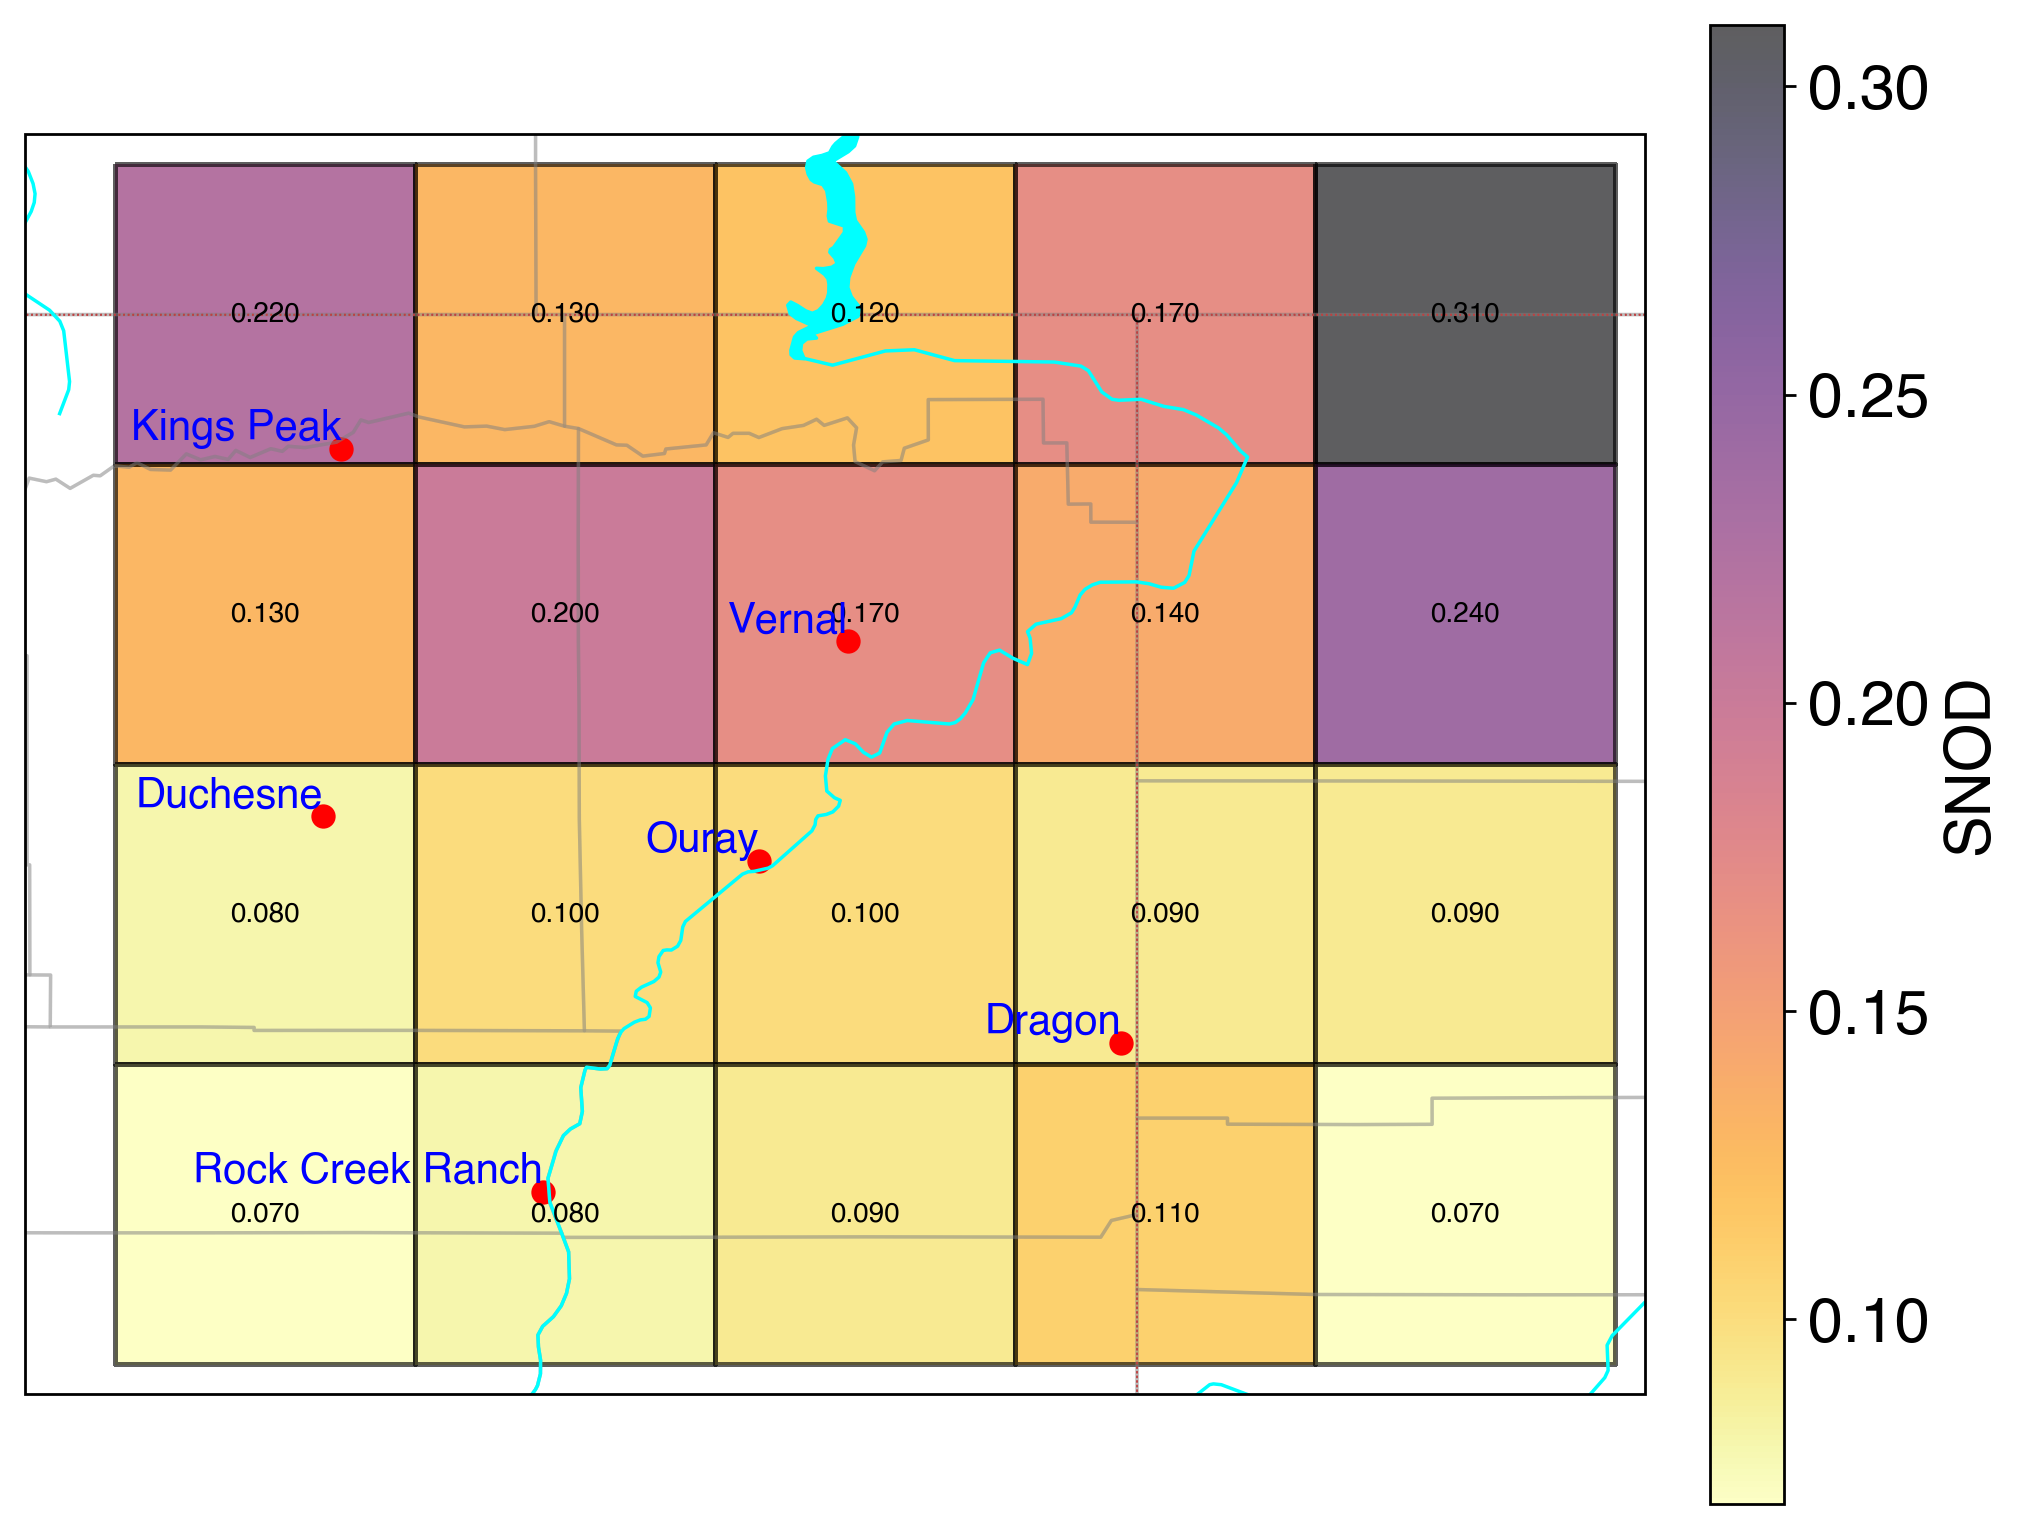

In [6]:
ds_snow1 = GEFSData.get_cropped_data(init_dt, fxx=fchr, q_str=":SNOD:", product="atmos.5", remove_grib=remove_grib, member="c00")
fig, ax = plotting.surface_plot(ds_snow1, "sde", fchr=0, label="SNOD", save=None,
                                    my_extent=my_extent, annotate_vals=True, decimal_places=3,
                                    )
fig.show()


In [7]:
ds_snow1

<xarray.Dataset> Size: 208B
Dimensions:              (latitude: 4, longitude: 5)
Coordinates:
    number               int64 8B 0
    time                 datetime64[ns] 8B 2023-02-15
    step                 timedelta64[ns] 8B 00:00:00
    surface              float64 8B 0.0
  * latitude             (latitude) float64 32B 41.0 40.5 40.0 39.5
  * longitude            (longitude) float64 40B -110.5 -110.0 ... -109.0 -108.5
    valid_time           datetime64[ns] 8B ...
    gribfile_projection  object 8B None
    metpy_crs            object 8B Projection: latitude_longitude
Data variables:
    sde                  (latitude, longitude) float32 80B 0.22 0.13 ... 0.07
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.5
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2023...
    local_grib:              /Users/johnlawson/data/gefs/20230215/subset_8aef...
    search:                  :SNOD:

In [8]:
# Compare forecast snow depth per grid cell to representative observation
# Number the grid cells so we can refer to them?
# This is (4,5) in the 0.5 degree grid
shp = ds_snow1.sde.shape
shp

(4, 5)

In [9]:
grid_nums = np.arange(shp[0] * shp[1])
grid_nums_df = grid_nums.reshape(shp)
grid_nums_df

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [10]:
# For each local date, get GEFS 06Z UTC run (T=24h - T=0)
# Compare each grid point to representative obs

# Keys for GEFS 0p5:
# vrbls = ["SDE",]
# We need insolation, which is either explicit or derived from cloud cover, elevation, lat, lon.
# We need snow depth/accumulation - Michael's work on snow shadow and geographical snowfall distribution
# We need wind speed, maybe gust?. Maybe at higher level and bias-correct for surface
# We need MSLP for near KVEL



✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4815/852245161.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


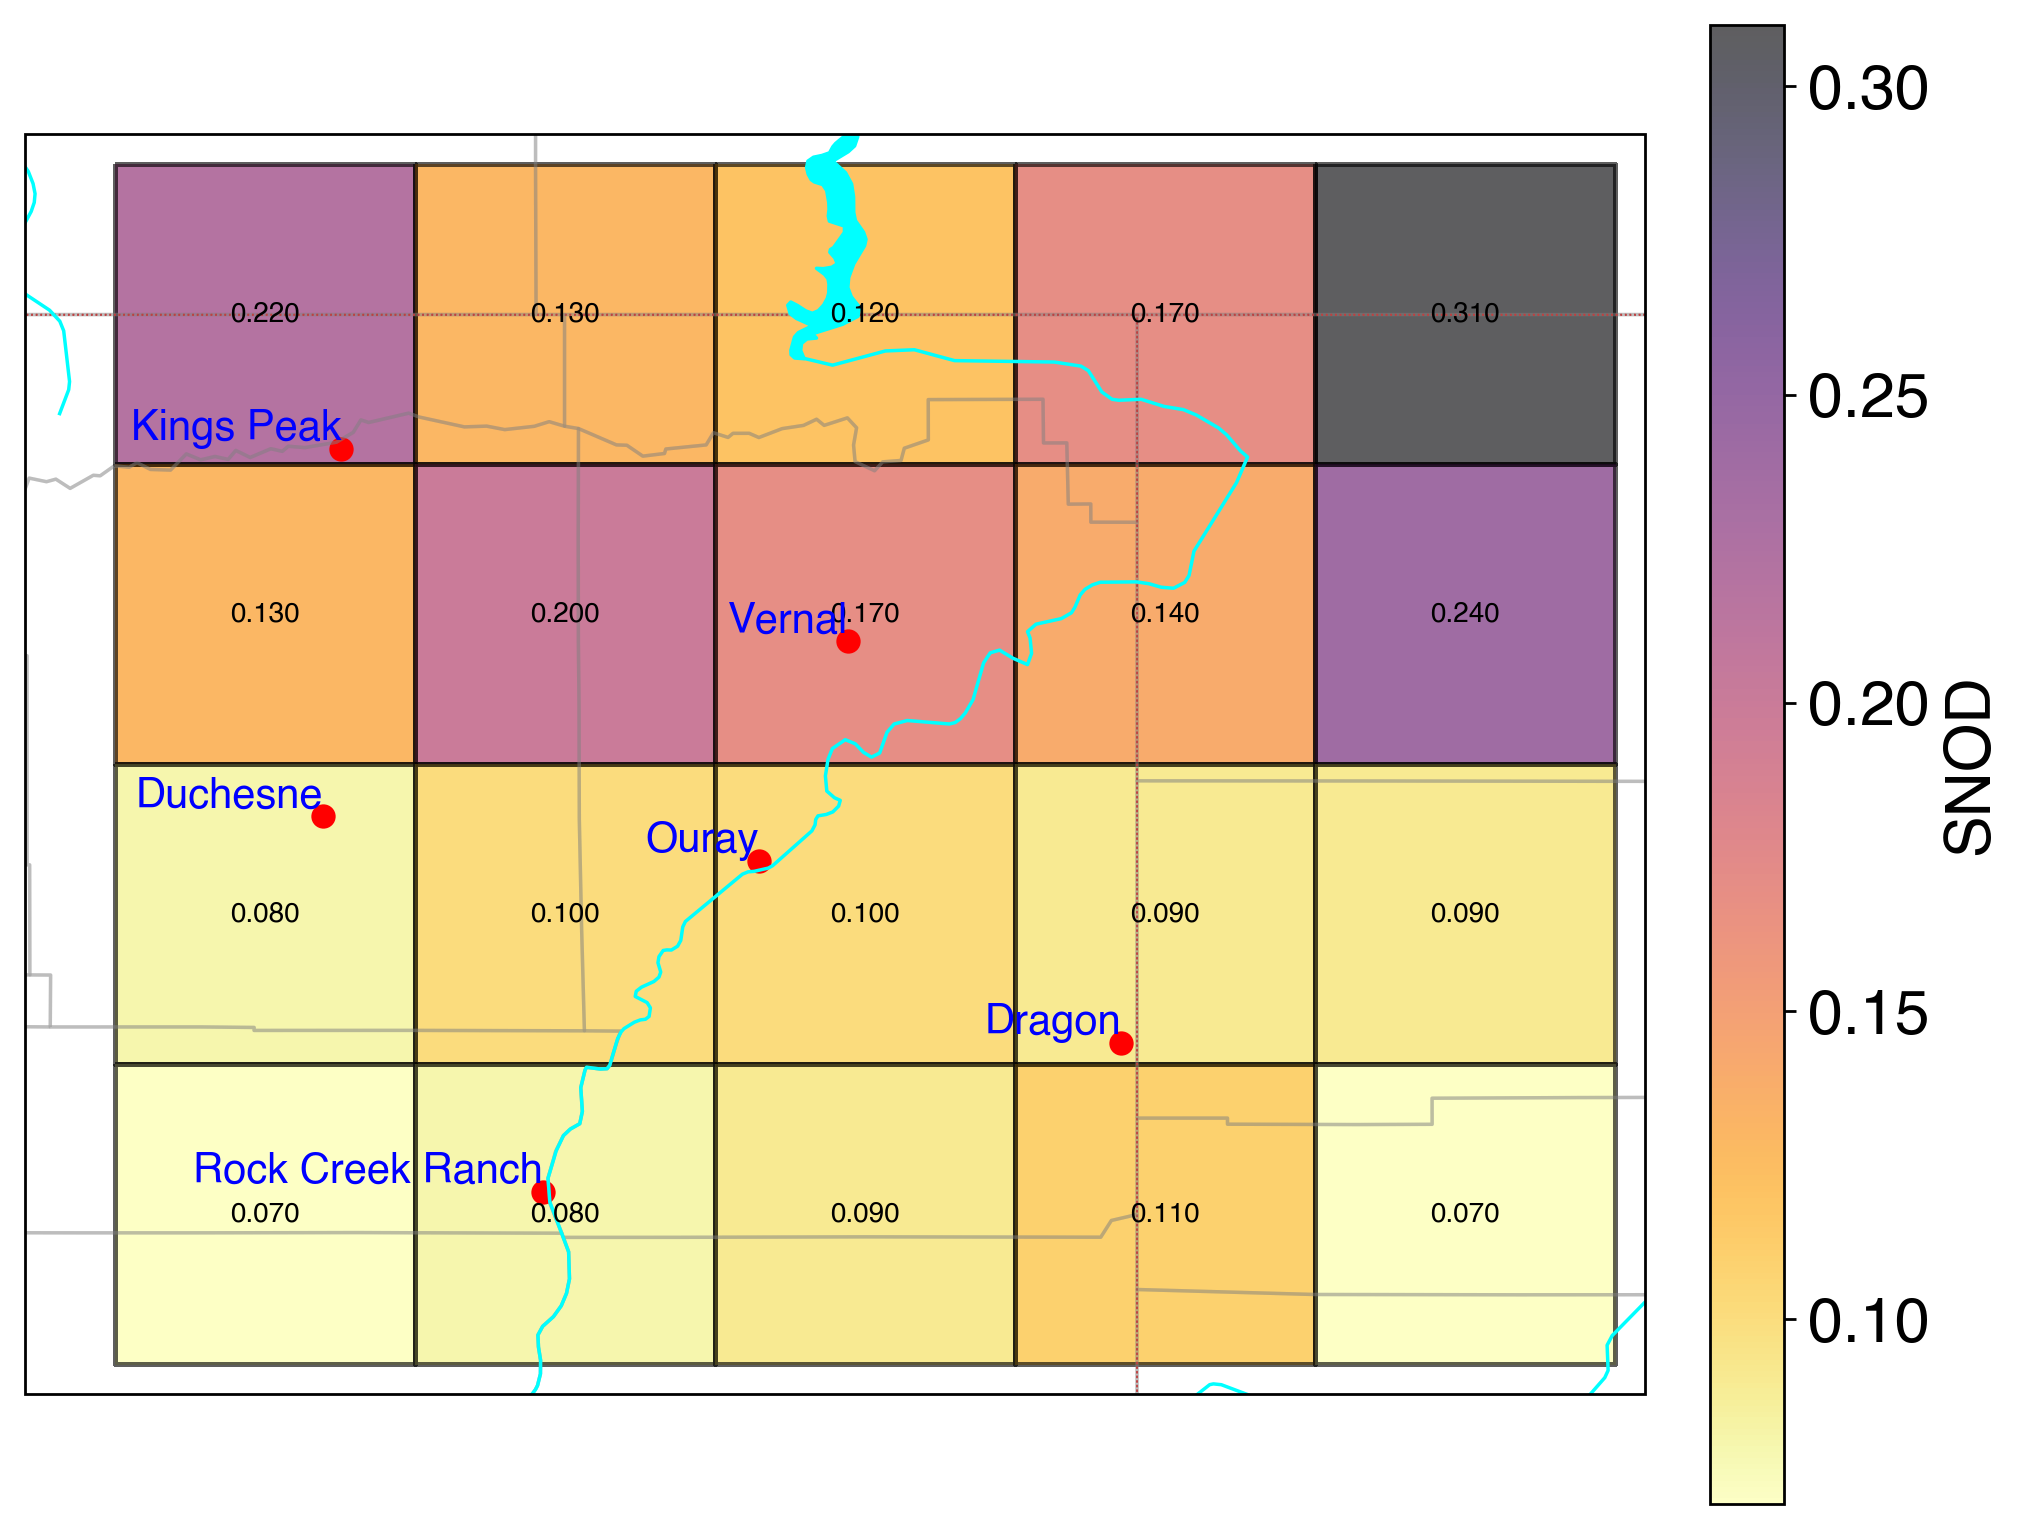

In [11]:
# For different ensemble members - percentiles etc

ds_snow2 = GEFSData.get_cropped_data(init_dt, fxx=fchr, q_str=":SNOD:", product="atmos.5", remove_grib=remove_grib, member="p01")
fig, ax = plotting.surface_plot(ds_snow2, "sde", fchr=0, label="SNOD", save=None,
                                my_extent=my_extent, annotate_vals=True, decimal_places=3,
                                )
fig.show()

## What about GEFS 0.25?

✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4815/1007650393.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


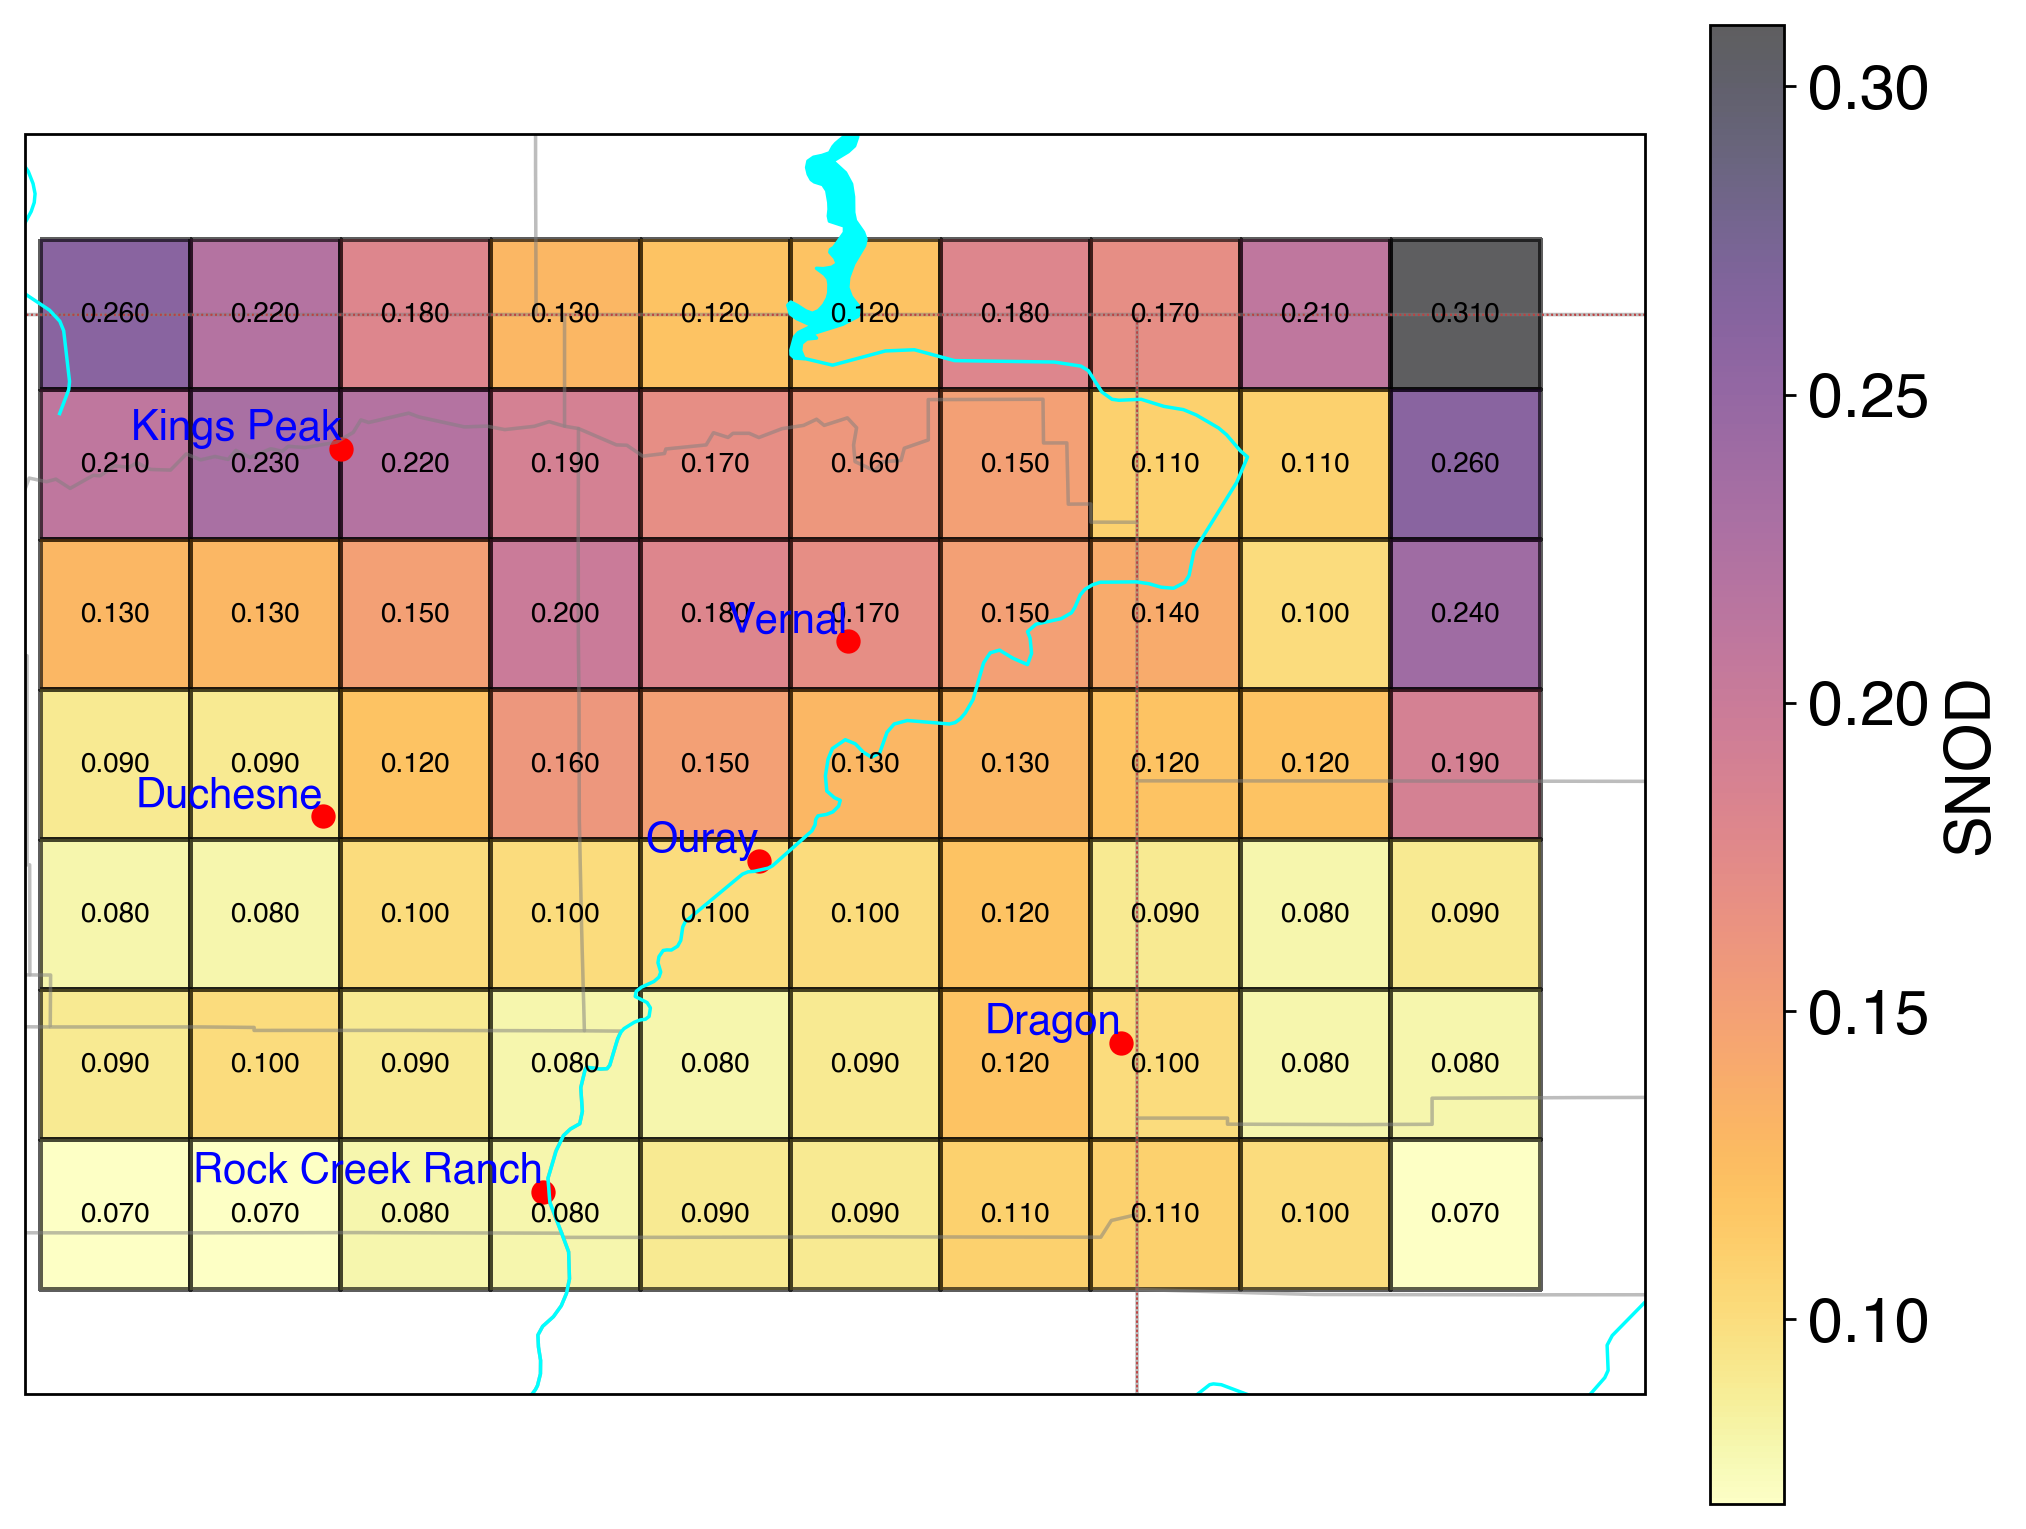

In [12]:
ds_snow3 = GEFSData.get_cropped_data(init_dt, fxx=fchr, q_str=":SNOD:", product="atmos.25", remove_grib=remove_grib)
fig, ax = plotting.surface_plot(ds_snow3, "sde", fchr=0, label="SNOD", save=None,
                                my_extent=my_extent, annotate_vals=True, decimal_places=3,
                                )
fig.show()


✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4815/3927252460.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


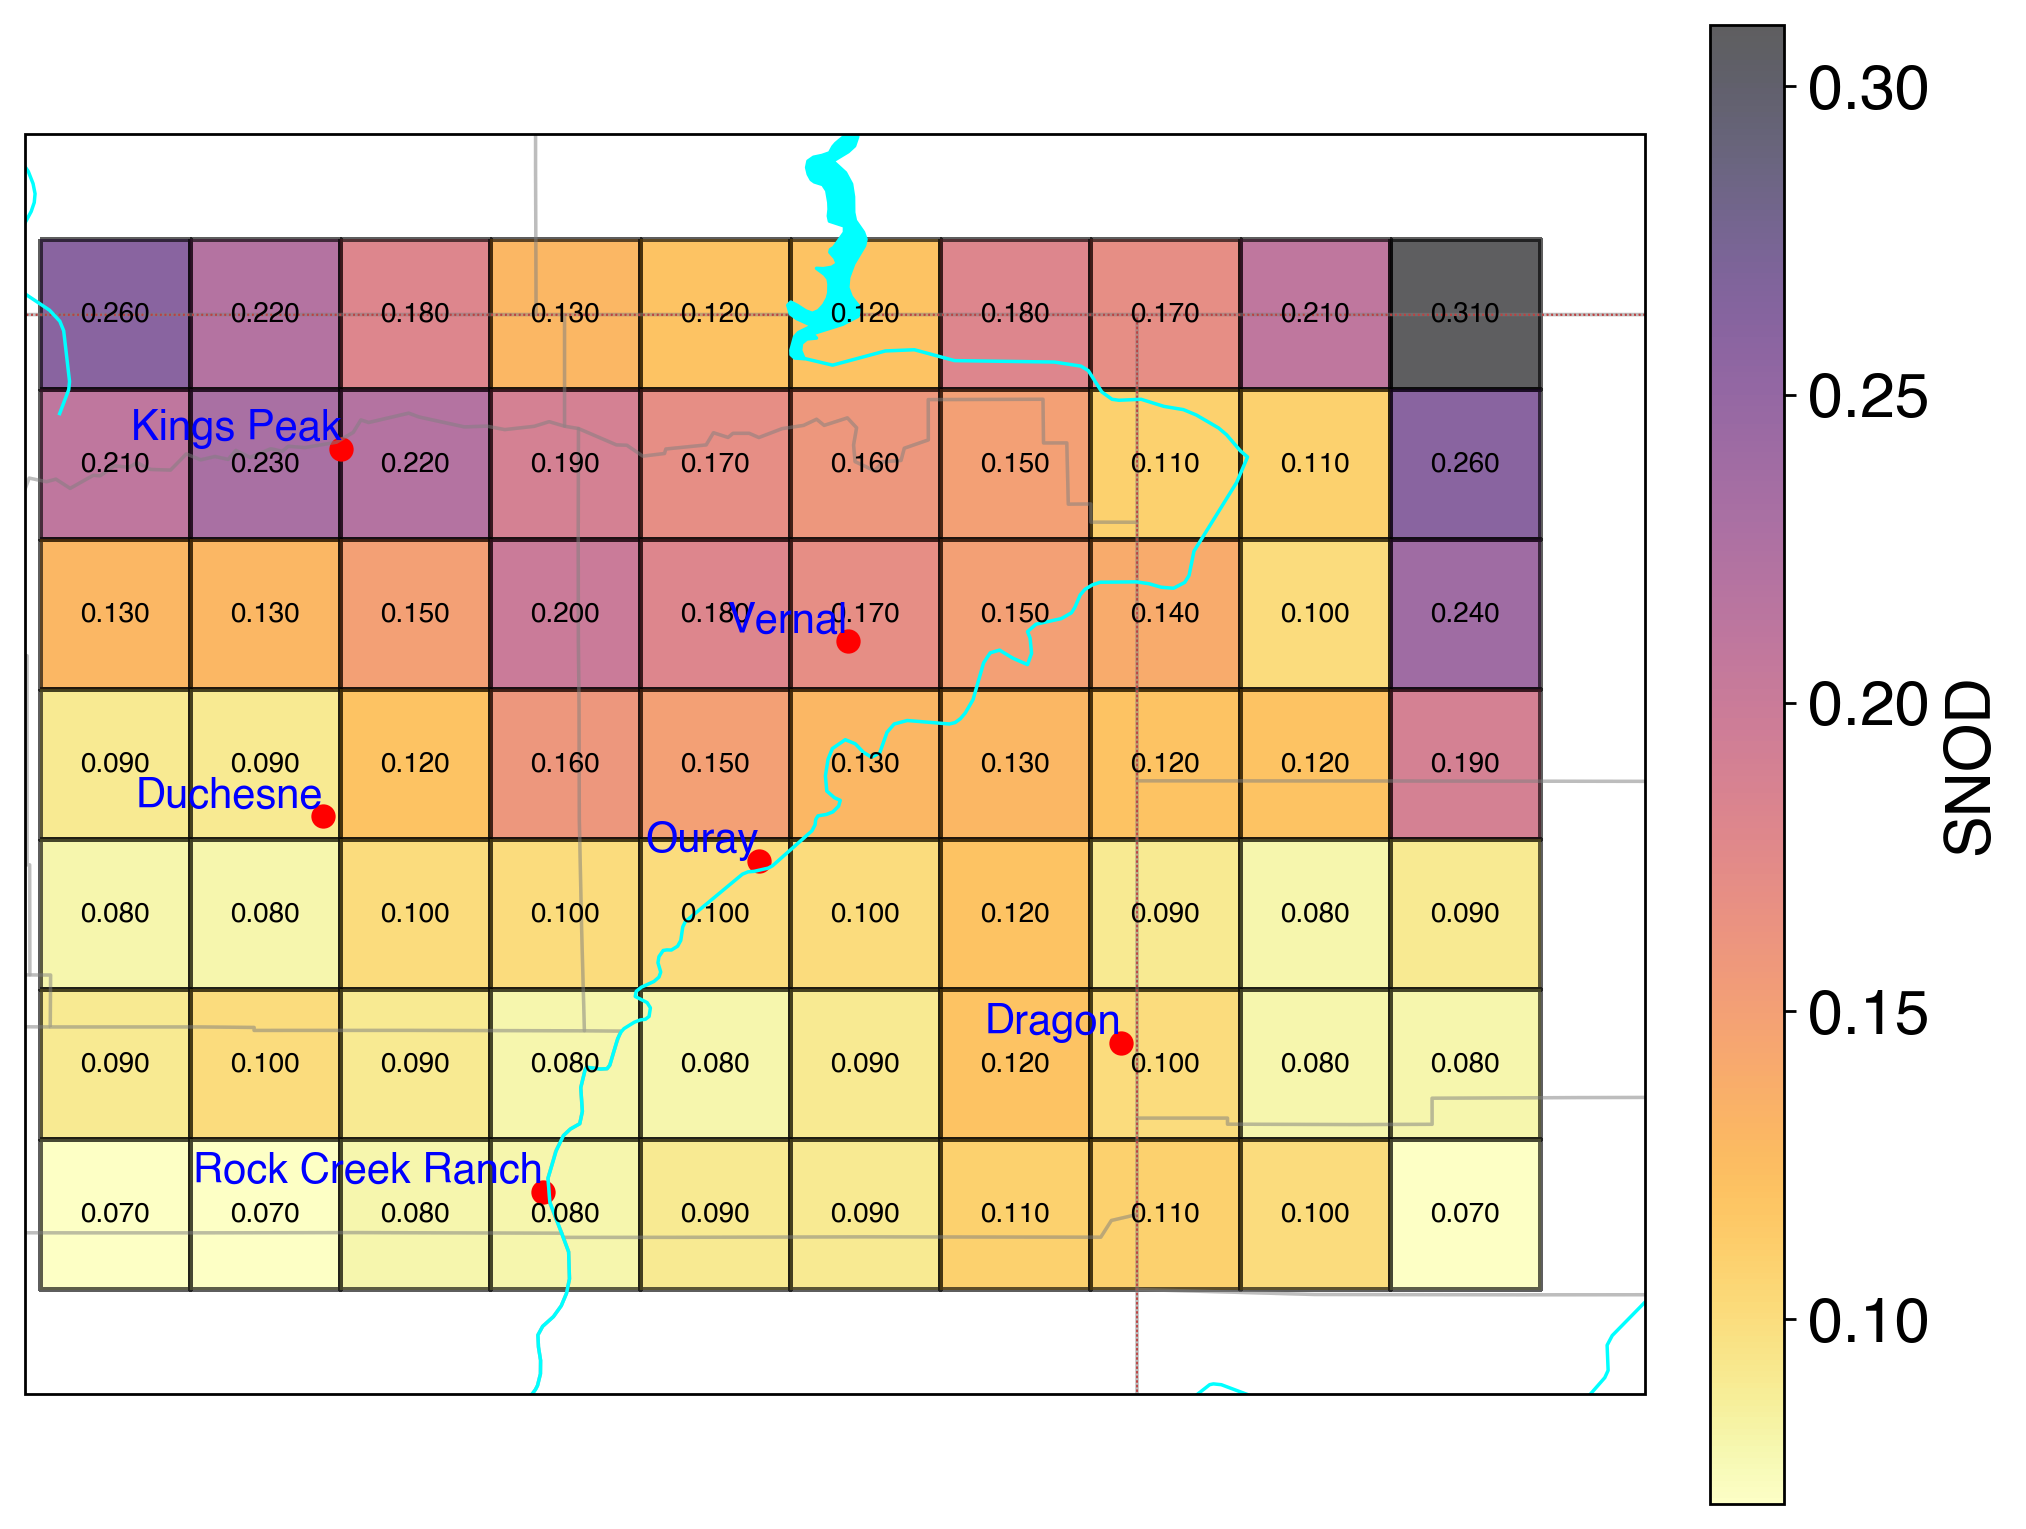

In [13]:
ds_snow4 = GEFSData.get_cropped_data(init_dt, fxx=fchr, q_str=":SNOD:", product="atmos.25", remove_grib=remove_grib, member='p01')
fig, ax = plotting.surface_plot(ds_snow4, "sde", fchr=0, label="SNOD", save=None,
                                my_extent=my_extent, annotate_vals=True, decimal_places=3,
                                )
fig.show()


✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_4815/3438308304.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


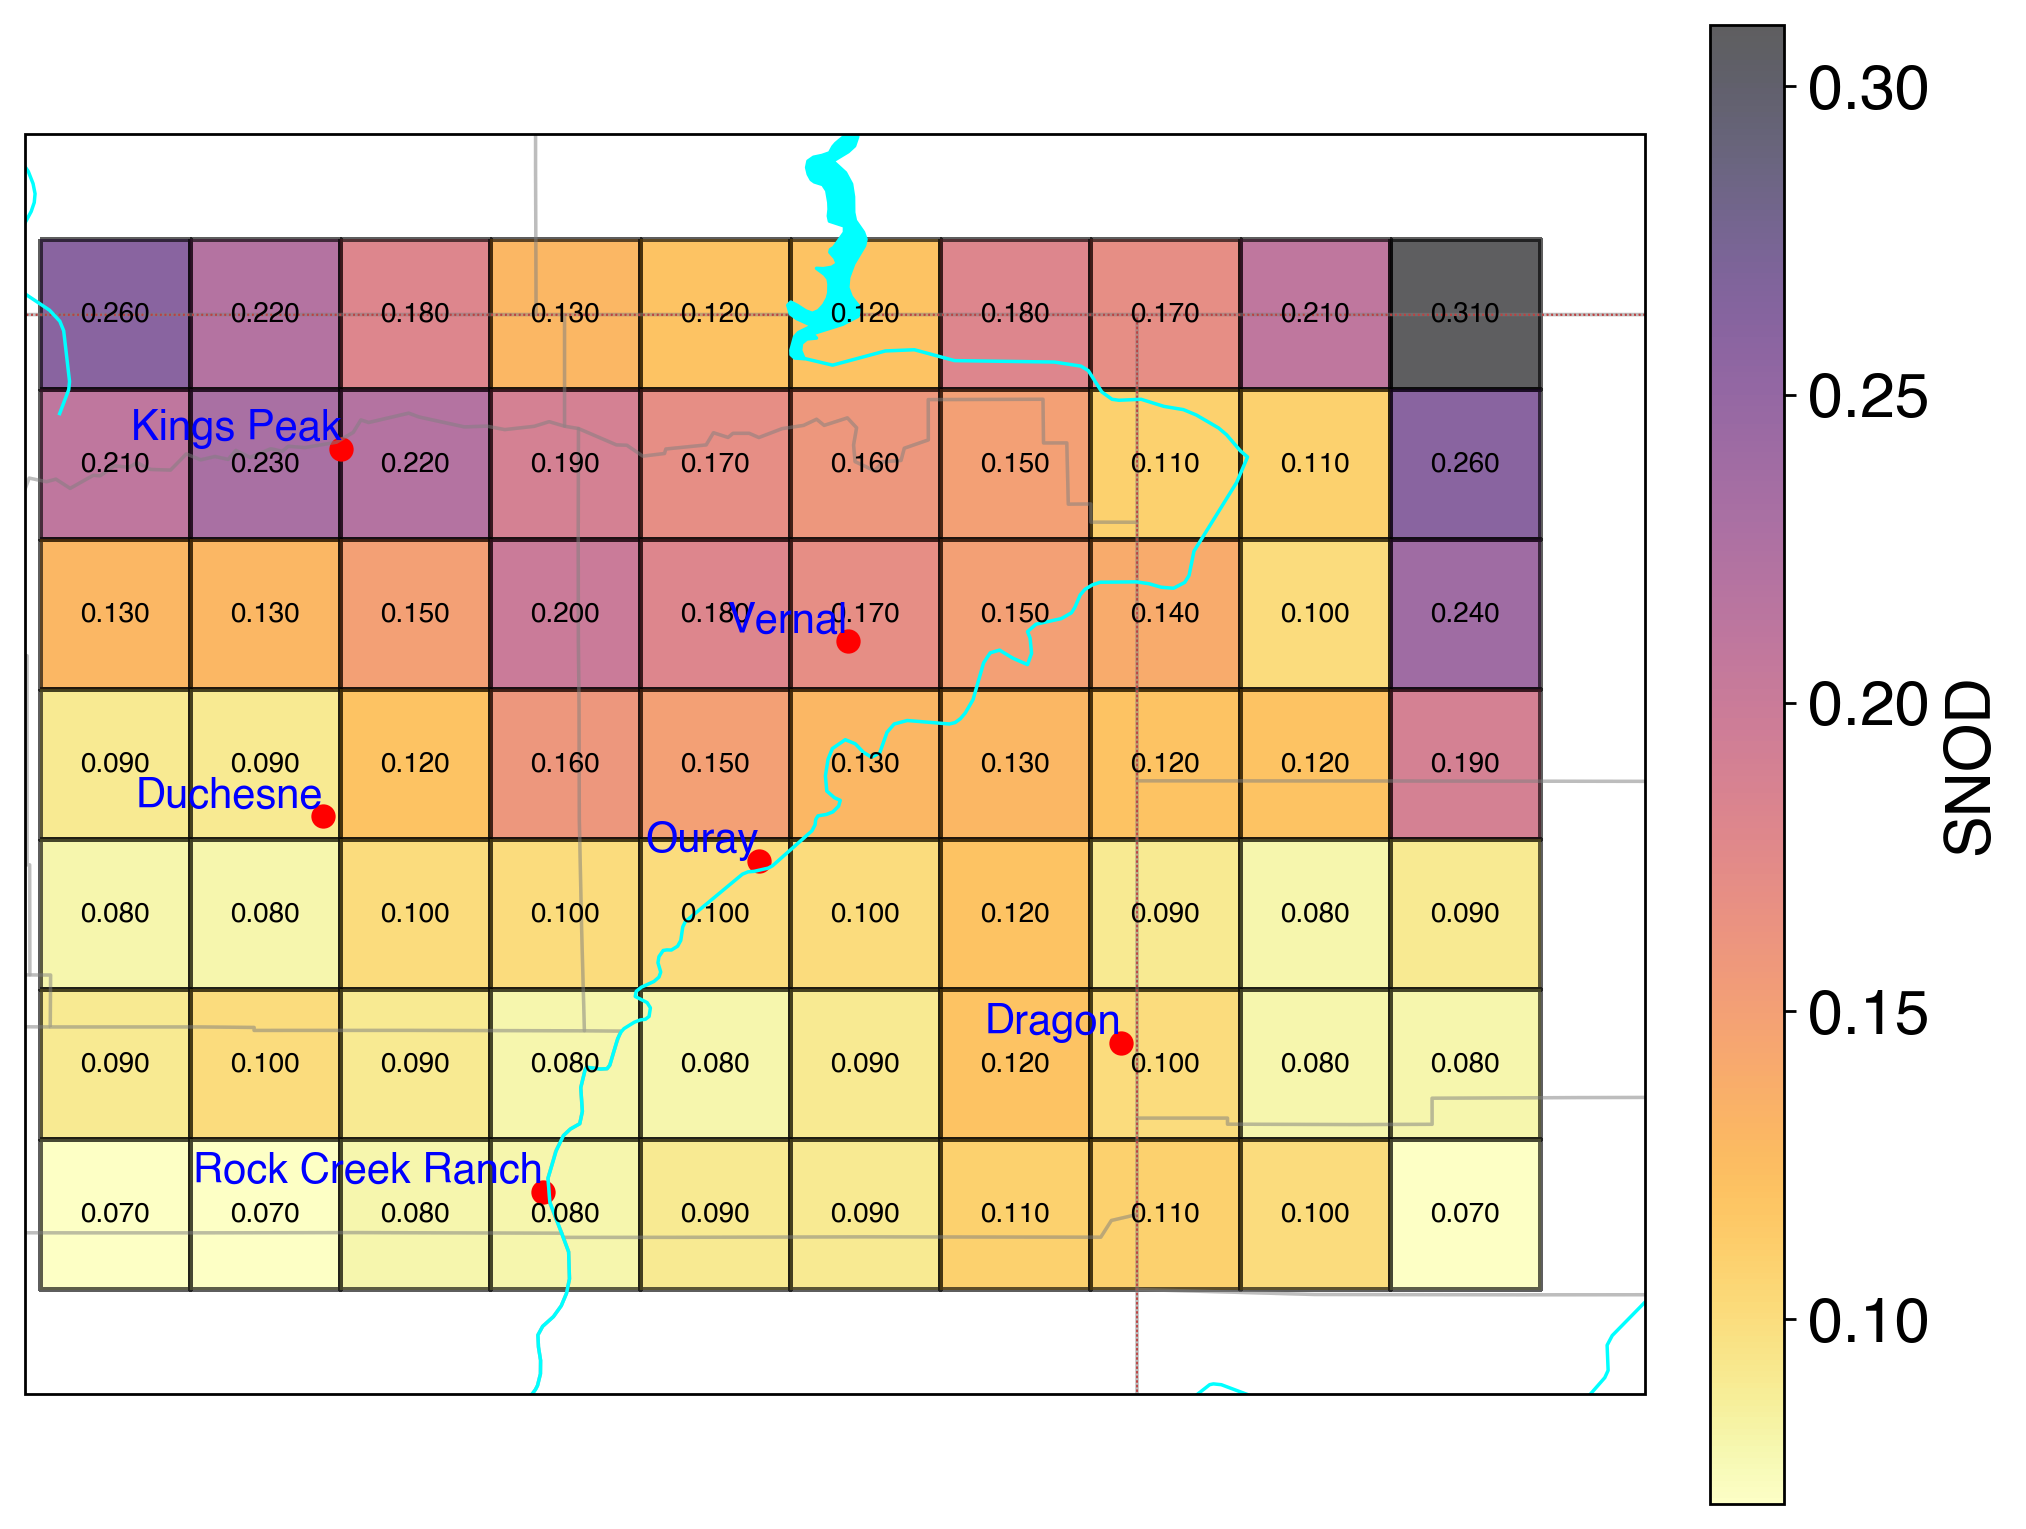

In [14]:
ds_snow4 = GEFSData.get_cropped_data(init_dt, fxx=fchr, q_str=":SNOD:", product="atmos.25", remove_grib=remove_grib, member='p02')
fig, ax = plotting.surface_plot(ds_snow4, "sde", fchr=0, label="SNOD", save=None,
                                my_extent=my_extent, annotate_vals=True, decimal_places=3,
                                )
fig.show()

In [15]:
# Elevation of the same matrix of data
# dem_getter git repo has useful code - copy/paste into utils and cite?
# TODO later - get DEM data

# Want to find 10 grid cells at Basin level

In [16]:
# plot each grid cell of snow depth with the representative value.

df, meta_df = ObsData.load_dfs("../data", f"UB_obs_{year}.parquet")
# repr_wind = do_repval_wind(df, snow_stids)
# repr_snow
df

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,solar_radiation,dew_point_temperature_set_1d,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2022-12-01 00:00:00+00:00,-5.000,101693.203125,NaN,NaN,-12.11,83777.976562,NaN,102371.351562,0.000000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:05:00+00:00,-3.000,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.000000,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:10:00+00:00,-3.000,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,260.000000,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:15:00+00:00,-3.000,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.000000,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:20:00+00:00,-4.000,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102262.531250,260.000000,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-14 23:20:00+00:00,-1.878,NaN,NaN,NaN,-3.83,NaN,NaN,NaN,244.500000,6.405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-14 23:30:00+00:00,-1.911,NaN,NaN,NaN,-3.99,NaN,NaN,NaN,242.100006,7.146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-14 23:40:00+00:00,-1.911,NaN,NaN,NaN,-3.97,NaN,NaN,NaN,246.000000,7.089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
repr_snow = do_repval_snow(df, snow_stids)


✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F108 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00

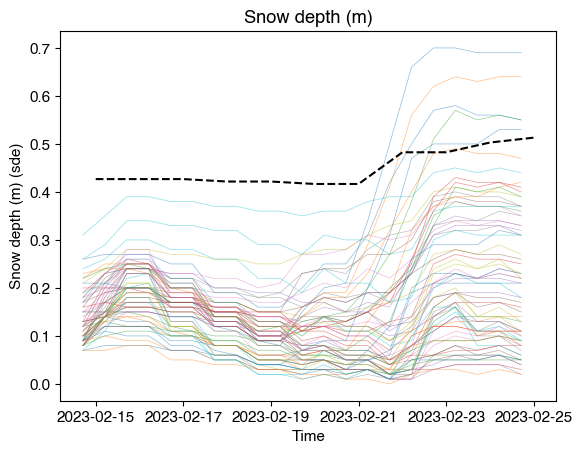

In [18]:
# Load and plot NWP data
# init_dt = datetime.datetime(2023, 2, 15, 0, 0, 0)
# max_h = 36
max_h = 240
delta_h = 12
q_str = ":SNOD:"
product = "atmos.25"
member = 'c00'
# my_extent = [-110.9, -108.2, 41.3, 39.2]
v_key = "sde"
repr_col_name = "snow_depth"
label = "Snow depth (m)"

# TODO - in operations we initialise the forecast data with the representative observation - we use change in depth

ds_snow_time_series = load_variable(init_dt, max_h, delta_h, q_str, product, member)
repr_snow_subset = repr_snow.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]

# This is not ensemble members, it's grid cells for the "member".
plot_ensemble_members(ds_snow_time_series, v_key, repr_snow_subset/1E3, max_h, init_dt, repr_col_name, label)

✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F108 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00

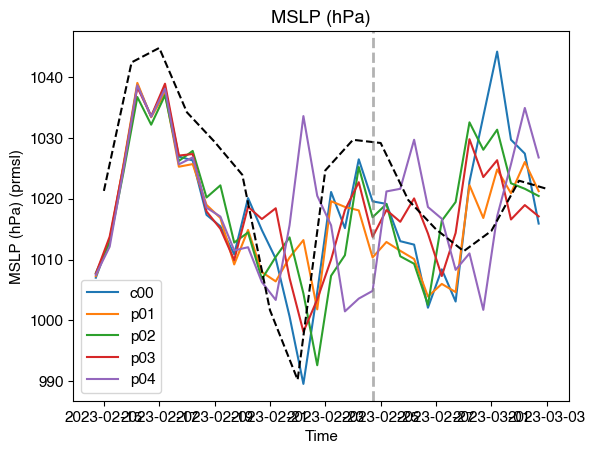

In [21]:
# Now let's loop over 5 ensemble members, and plot the mean of all grid cells for each member
# and compare to the representative value

repr_mslp = do_repval_mslp(df, mslp_stids)

q_str = ":PRMSL:"
product = "atmos.25"
member = 'p02'
v_key = "prmsl"
label = "MSLP (hPa)"
repr_col_name = "sea_level_pressure"

# max_h = 240 # Limit of GEFS 0.25
max_h = 384 # Limit of GEFS 0.5
delta_h = 12

fig,ax = plt.subplots(1)
for member in ['c00', 'p01', 'p02', 'p03', 'p04']:
    ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member)
    repr_mslp_subset = repr_mslp.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]
    mean_mslp = ds_ts.mean(dim=['latitude', 'longitude'])[v_key]/1E2
    ax.plot(ds_ts.time, mean_mslp, label=member)

ax.plot(repr_mslp_subset.index, repr_mslp_subset[repr_col_name]/1E2, color='black', linestyle='--')
# Vertical line where we switch to using coarser GEFS data (240 hours; faint, thick, grey dotted line)
ax.axvline(x=init_dt + datetime.timedelta(hours=240), color='grey', linestyle='--', alpha=0.6, linewidth=2)
ax.set_title(f'{label}')
ax.set_xlabel('Time')
ax.set_ylabel(f'{label} ({v_key})')
ax.legend()

# TODO - scatter markers for repr value where marked is red/green if it falls within max/min for that time

plt.show()

In [22]:
repr_mslp.describe()

,sea_level_pressure
count,105.000000
mean,102833.890513
std,1170.776756
min,99023.613281
25%,102096.167969
50%,102826.265625
75%,103714.820312
max,105211.171875


✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F36 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F48 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F60 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F72 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F84 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F96 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F108 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00

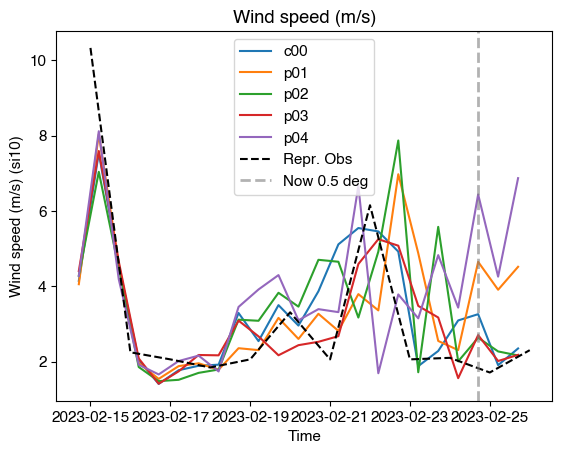

In [23]:
# q_str = ":UGRD:"
q_str = "GRD:10 m above"
product = "atmos.25"
member = 'p02'
v_key = "si10"
label = "Wind speed (m/s)"
repr_col_name = "wind_speed"

# max_h = 240 # Limit of GEFS 0.25
max_h = 265 # One day over to test GEFS 0.5 load
# max_h = 384 # Limit of GEFS 0.5
# max_h = 37
delta_h = 12

repr_wind = do_repval_wind(df, wind_stids)

fig,ax = plt.subplots(1)
for member in ['c00', 'p01', 'p02', 'p03', 'p04']:
    ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member)
    ds_ts = ds_ts.herbie.with_wind("speed")
    pass
    repr_wind_subset = repr_wind.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]
    mean_wind = ds_ts.mean(dim=['latitude', 'longitude'])[v_key]
    ax.plot(ds_ts.time, mean_wind, label=member)

ax.plot(repr_wind_subset.index, repr_wind_subset[repr_col_name], color='black',
            linestyle='--', label='Repr. Obs')
# Vertical line where we switch to using coarser GEFS data (240 hours; faint, thick, grey dotted line)
ax.axvline(x=init_dt + datetime.timedelta(hours=240), color='grey', linestyle='--',
                alpha=0.6, linewidth=2, label='Now 0.5 deg')
ax.set_title(f'{label}')
ax.set_xlabel('Time')
ax.set_ylabel(f'{label} ({v_key})')
ax.legend()

plt.show()


# ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member)
# repr_wind_subset = repr_wind.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]
# plot_ensemble_members(ds_ts, v_key, repr_wind_subset, max_h, init_dt, repr_col_name, label)

✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F27 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.25 ┊ 2023-Feb-15 00:00 

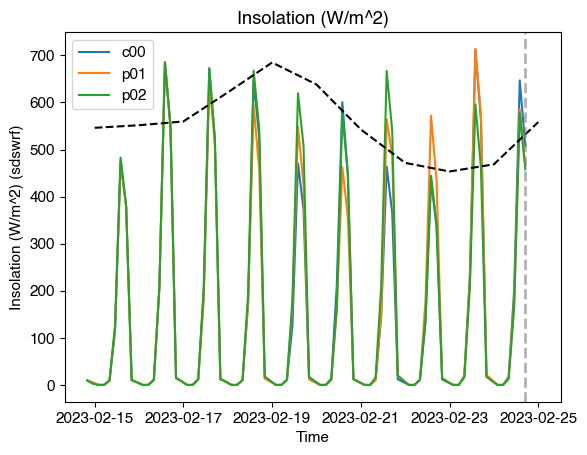

In [24]:
# DSWRF - Downward shortwave radiation flux
q_str = ":DSWRF:"
product = "atmos.25"
member = 'p02'
v_key = "sdswrf"
label = "Insolation (W/m^2)"
repr_col_name = "solar_radiation"

max_h = 240 # Limit of GEFS 0.25
# max_h = 265 # One day over to test GEFS 0.5 load
# max_h = 384 # Limit of GEFS 0.5
# max_h = 73
# max_h = 72
delta_h = 3

repr_solar = do_repval_solar(df, solar_stids)

fig,ax = plt.subplots(1)
for member in ['c00', 'p01', 'p02',]:
    ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member, skip_first_n=1)
    # Drop rows where the column has NaN
    repr_solar_subset = repr_solar.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)].dropna(axis=0)
    mean_solar = ds_ts.mean(dim=['latitude', 'longitude'])[v_key]
    ax.plot(ds_ts.time, mean_solar, label=member)

# TODO - recreate solar representative because they are Series not DataFrame.
ax.plot(repr_solar_subset.index, repr_solar_subset, color='black', linestyle='--')
# ax.plot(repr_solar_subset.index, repr_solar_subset[repr_col_name], color='black', linestyle='--')

# Vertical line where we switch to using coarser GEFS data (240 hours; faint, thick, grey dotted line)
ax.axvline(x=init_dt + datetime.timedelta(hours=240), color='grey', linestyle='--', alpha=0.6, linewidth=2)
ax.set_title(f'{label}')
ax.set_xlabel('Time')
ax.set_ylabel(f'{label} ({v_key})')
ax.legend()

plt.show()

# TODO - interpolate the 0.5 data to get 3-hourly data to capture solar noon?...

# ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member)
# repr_wind_subset = repr_wind.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]
# plot_ensemble_members(ds_ts, v_key, repr_wind_subset, max_h, init_dt, repr_col_name, label)

In [26]:
repr_solar

date_time
2022-12-01 00:00:00-07:00           NaN
2022-12-02 00:00:00-07:00           NaN
2022-12-03 00:00:00-07:00           NaN
2022-12-04 00:00:00-07:00    355.891352
2022-12-05 00:00:00-07:00    334.940498
                                ...    
2023-03-10 00:00:00-07:00    591.231270
2023-03-11 00:00:00-07:00    646.742255
2023-03-12 00:00:00-07:00    576.950451
2023-03-13 00:00:00-06:00    515.579698
2023-03-14 00:00:00-06:00    529.507444
Name: solar_radiation, Length: 104, dtype: float64

In [27]:
ds_ts


<xarray.Dataset> Size: 24kB
Dimensions:              (time: 80, latitude: 7, longitude: 10)
Coordinates:
    number               int64 8B 2
  * time                 (time) datetime64[ns] 640B 2023-02-15T03:00:00 ... 2...
    step                 (time) timedelta64[ns] 640B 03:00:00 ... 10 days 00:...
    surface              float64 8B 0.0
  * latitude             (latitude) float64 56B 41.0 40.75 40.5 ... 39.75 39.5
  * longitude            (longitude) float64 80B -110.8 -110.5 ... -108.8 -108.5
    valid_time           (time) datetime64[ns] 640B 2023-02-15T03:00:00 ... 2...
    gribfile_projection  object 8B None
    metpy_crs            object 8B Projection: latitude_longitude
Data variables:
    sdswrf               (time, latitude, longitude) float32 22kB 10.0 ... 386.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 atmos.25
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2023...
    local_grib:              /Users/johnlawson/data/gefs/20230215/subset_8a15...
    search:                  :DSWRF:

In [25]:
assert True is False

AssertionError: 

In [ ]:
# PRMSL - mean sea level pressure
q_str = ":PRMSL:"
product = "atmos.25"
member = 'p02'
v_key = "prmsl"
label = "MSLP (hPa)"
repr_col_name = "sea_level_pressure"

ds_ts = load_variable(init_dt, max_h, delta_h, q_str, product, member)
repr_mslp_subset = repr_mslp.loc[init_dt_tz:init_dt_tz + datetime.timedelta(hours=max_h)]

# This is not ensemble members, it's grid cells for the "member".
plot_ensemble_members(ds_ts/1E2, v_key, repr_mslp_subset/1E2, max_h, init_dt, repr_col_name, label)